# ЛР2 — Классификация возраста, пола и расы по лицу человека
---
*Зубарева Марина, РИМ-281226*

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
from torch.utils import data
import re

resize_size = 224

T = transforms.Compose([
    transforms.Resize([resize_size,resize_size]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age = int(ID.split('/')[-1].split('_')[0])
        gender = int(ID.split('/')[-1].split('_')[1])
        race = int(ID.split('/')[-1].split('_')[2])
        
        for i in range(6):
            group_age = range(self.age_list[i][0], self.age_list[i][1])
            if age in group_age:
                age = i
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender, race
    
def plain_to_labels(age, gender, race):
    gender_dict = {0:"male", 1:"female"}
    race_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Not common race"}
    age_dict = {0:"0-5", 1:"5-14", 2:"14-30", 3:"30-45", 4:"45-60", 5:"60+"}
    
    # костыль tensor(%d) -> %d    
    age = int(re.findall(r"\d", str(age))[0])
    gender = int(re.findall(r"\d", str(gender))[0])
    race = int(re.findall(r"\d", str(race))[0])

    age = age_dict.get(age)
    gender = gender_dict.get(gender)
    race = race_dict.get(race)
    
    return age, gender, race

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 !ls "/content/drive/My Drive/crop_part1"

 10_0_0_20161220222308131.jpg.chip.jpg
 10_0_0_20170103200329407.jpg.chip.jpg
 10_0_0_20170103200522151.jpg.chip.jpg
 10_0_0_20170103233459275.jpg.chip.jpg
 10_0_0_20170104013211746.jpg.chip.jpg
 10_0_0_20170110215927291.jpg.chip.jpg
 10_0_0_20170110220033115.jpg.chip.jpg
 10_0_0_20170110220111082.jpg.chip.jpg
 10_0_0_20170110220235233.jpg.chip.jpg
 10_0_0_20170110220251986.jpg.chip.jpg
 10_0_0_20170110220255346.jpg.chip.jpg
 10_0_0_20170110220316298.jpg.chip.jpg
 10_0_0_20170110220403810.jpg.chip.jpg
 10_0_0_20170110220447314.jpg.chip.jpg
 10_0_0_20170110220503946.jpg.chip.jpg
 10_0_0_20170110220514186.jpg.chip.jpg
 10_0_0_20170110220530650.jpg.chip.jpg
 10_0_0_20170110220539329.jpg.chip.jpg
 10_0_0_20170110220541850.jpg.chip.jpg
 10_0_0_20170110220546177.jpg.chip.jpg
 10_0_0_20170110220548521.jpg.chip.jpg
 10_0_0_20170110220557169.jpg.chip.jpg
 10_0_0_20170110220644705.jpg.chip.jpg
 10_0_0_20170110220654150.jpg.chip.jpg
 10_0_0_20170110221714752.jpg.chip.jpg
 10_0_0_20170110221719390

In [0]:
path_to_data = "/content/drive/My Drive/crop_part1"

In [0]:
train_data = Dataset(path_to_data, subset='train', test_part = 0.2, transform = T)
valid_data = Dataset(path_to_data, subset='valid', test_part = 0.2, transform = T)

In [7]:
print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train data len:  1957
valid data len:  7828


30-45
female
White


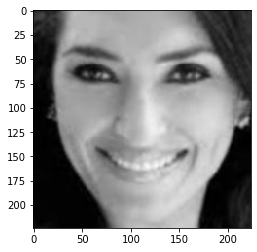

In [8]:
img, age, gender, race = train_data[0]
age, gender, race = plain_to_labels(age, gender, race)
print(age)
print(gender)
print(race)
plt.imshow(img.numpy().transpose(1,2,0))

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=16, 
                                          shuffle=False)

14-30 female Indian
14-30 male Black
14-30 male White
0-5 male White
45-60 male Not common race
0-5 female White
0-5 male Not common race
0-5 male White
60+ male White
5-14 male Indian
14-30 female Indian
0-5 female Not common race
60+ male White
60+ female White
14-30 male White
30-45 male Not common race


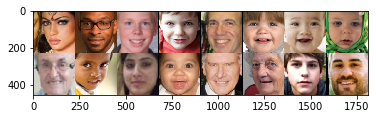

In [10]:
images, age, gender, race = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

for i in range(len(age)):
    age_i, gender_i, race_i = plain_to_labels(age[i], gender[i], race[i])
    print(age_i, gender_i, race_i)

In [0]:
model_labels = ['resnet50', 'resnet34', 'mobilenetv2']
optimizer_labels = ['SGD', 'Adam']
NUMBER_OF_EPOCHS = 10
epochs_count = NUMBER_OF_EPOCHS

predict_demo_packs_limit = 1

In [0]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            size = 1280 * 7 * 7
            self.model = models.mobilenet_v2(pretrained=True)
            self.model.classifier = nn.Dropout(p=0.2, inplace=False)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)
            # code here
        elif self.net == 'resnet34':
            size = 512
            self.model = models.resnet34(pretrained=True)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)
            # code here
        elif self.net == 'resnet50':
            size = 2048
            self.model = models.resnet50(pretrained=True)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)


    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
            
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = self.model.classifier(x) # only dropout
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)

        
        return age, gender, race

Model: resnet50
Training with SGD optimizer
Training start. Total number of epochs: 10
Epoch 1, loss: 3.916, val_loss: 3.755 
 +                acc_age: 0.234, val_acc_age: 0.282 
  +                acc_gender: 0.577, val_acc_gender: 0.574 
  +                acc_race: 0.430, val_acc_race: 0.538
Epoch 2, loss: 3.697, val_loss: 3.670 
 +                acc_age: 0.296, val_acc_age: 0.324 
  +                acc_gender: 0.602, val_acc_gender: 0.607 
  +                acc_race: 0.541, val_acc_race: 0.538
Epoch 3, loss: 3.645, val_loss: 3.622 
 +                acc_age: 0.312, val_acc_age: 0.343 
  +                acc_gender: 0.613, val_acc_gender: 0.614 
  +                acc_race: 0.541, val_acc_race: 0.538
Epoch 4, loss: 3.570, val_loss: 3.567 
 +                acc_age: 0.348, val_acc_age: 0.376 
  +                acc_gender: 0.635, val_acc_gender: 0.632 
  +                acc_race: 0.541, val_acc_race: 0.538
Epoch 5, loss: 3.523, val_loss: 3.527 
 +                acc_age: 0.361, 

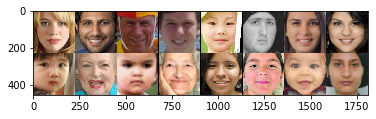

1 : 14-30 female White
2 : 14-30 female White
3 : 14-30 female White
4 : 14-30 male White
5 : 0-5 female White
6 : 14-30 male White
7 : 0-5 female White
8 : 14-30 female White
9 : 0-5 female White
10 : 60+ female White
11 : 0-5 male White
12 : 60+ female White
13 : 14-30 female White
14 : 0-5 female White
15 : 0-5 female White
16 : 14-30 female White
Training with Adam optimizer
Training start. Total number of epochs: 10
Epoch 1, loss: 3.408, val_loss: 3.354 
 +                acc_age: 0.407, val_acc_age: 0.479 
  +                acc_gender: 0.593, val_acc_gender: 0.630 
  +                acc_race: 0.548, val_acc_race: 0.589
Epoch 2, loss: 2.854, val_loss: 3.107 
 +                acc_age: 0.508, val_acc_age: 0.503 
  +                acc_gender: 0.675, val_acc_gender: 0.652 
  +                acc_race: 0.619, val_acc_race: 0.597
Epoch 3, loss: 2.620, val_loss: 3.641 
 +                acc_age: 0.569, val_acc_age: 0.489 
  +                acc_gender: 0.719, val_acc_gender: 0.630 
 

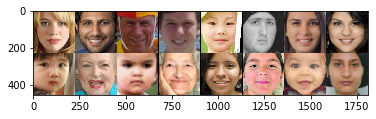

1 : 14-30 female White
2 : 30-45 male White
3 : 60+ male White
4 : 30-45 male White
5 : 5-14 male Asian
6 : 30-45 female White
7 : 14-30 female White
8 : 14-30 female White
9 : 0-5 female Asian
10 : 60+ female White
11 : 0-5 female Indian
12 : 30-45 male White
13 : 5-14 female White
14 : 0-5 male Asian
15 : 0-5 female Not common race
16 : 14-30 female White
Model: resnet34
Training with SGD optimizer
Training start. Total number of epochs: 10
Epoch 1, loss: 4.181, val_loss: 3.948 
 +                acc_age: 0.206, val_acc_age: 0.236 
  +                acc_gender: 0.469, val_acc_gender: 0.511 
  +                acc_race: 0.369, val_acc_race: 0.513
Epoch 2, loss: 3.810, val_loss: 3.788 
 +                acc_age: 0.284, val_acc_age: 0.287 
  +                acc_gender: 0.554, val_acc_gender: 0.543 
  +                acc_race: 0.527, val_acc_race: 0.528
Epoch 3, loss: 3.679, val_loss: 3.677 
 +                acc_age: 0.307, val_acc_age: 0.324 
  +                acc_gender: 0.583, va

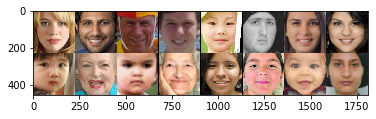

1 : 0-5 female White
2 : 14-30 female White
3 : 60+ male White
4 : 45-60 female White
5 : 0-5 female White
6 : 14-30 female White
7 : 14-30 female White
8 : 14-30 female White
9 : 0-5 male White
10 : 60+ female White
11 : 0-5 male Indian
12 : 60+ female White
13 : 14-30 female White
14 : 14-30 male White
15 : 0-5 female Asian
16 : 14-30 female White
Training with Adam optimizer
Training start. Total number of epochs: 10
Epoch 1, loss: 3.084, val_loss: 3.528 
 +                acc_age: 0.487, val_acc_age: 0.400 
  +                acc_gender: 0.658, val_acc_gender: 0.705 
  +                acc_race: 0.594, val_acc_race: 0.578
Epoch 2, loss: 2.532, val_loss: 2.636 
 +                acc_age: 0.561, val_acc_age: 0.587 
  +                acc_gender: 0.738, val_acc_gender: 0.753 
  +                acc_race: 0.670, val_acc_race: 0.602
Epoch 3, loss: 2.249, val_loss: 2.485 
 +                acc_age: 0.612, val_acc_age: 0.590 
  +                acc_gender: 0.775, val_acc_gender: 0.780 
  

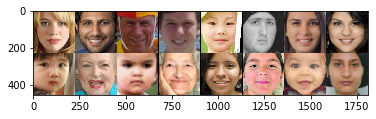

1 : 14-30 female White
2 : 30-45 male Not common race
3 : 45-60 male White
4 : 30-45 male White
5 : 60+ female Asian
6 : 14-30 female White
7 : 14-30 female White
8 : 14-30 female White
9 : 5-14 female Asian
10 : 60+ female White
11 : 0-5 female Indian
12 : 60+ female White
13 : 14-30 female Not common race
14 : 5-14 female White
15 : 0-5 female Indian
16 : 14-30 female White
Model: mobilenetv2
Training with SGD optimizer
Training start. Total number of epochs: 10
Epoch 1, loss: 3.383, val_loss: 2.810 
 +                acc_age: 0.400, val_acc_age: 0.527 
  +                acc_gender: 0.656, val_acc_gender: 0.755 
  +                acc_race: 0.556, val_acc_race: 0.597
Epoch 2, loss: 2.464, val_loss: 2.551 
 +                acc_age: 0.582, val_acc_age: 0.576 
  +                acc_gender: 0.786, val_acc_gender: 0.742 
  +                acc_race: 0.661, val_acc_race: 0.650
Epoch 3, loss: 2.108, val_loss: 2.441 
 +                acc_age: 0.658, val_acc_age: 0.563 
  +               

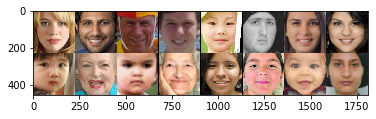

1 : 5-14 female White
2 : 30-45 male White
3 : 45-60 male White
4 : 14-30 male White
5 : 0-5 female Asian
6 : 14-30 male White
7 : 14-30 female White
8 : 5-14 female White
9 : 0-5 male Asian
10 : 60+ female White
11 : 0-5 male White
12 : 60+ female White
13 : 14-30 female Asian
14 : 14-30 male White
15 : 0-5 male Asian
16 : 14-30 female White
Training with Adam optimizer
Training start. Total number of epochs: 10
Epoch 1, loss: 10.114, val_loss: 3.391 
 +                acc_age: 0.383, val_acc_age: 0.510 
  +                acc_gender: 0.597, val_acc_gender: 0.637 
  +                acc_race: 0.490, val_acc_race: 0.542
Epoch 2, loss: 3.532, val_loss: 3.113 
 +                acc_age: 0.503, val_acc_age: 0.549 
  +                acc_gender: 0.677, val_acc_gender: 0.675 
  +                acc_race: 0.584, val_acc_race: 0.607
Epoch 3, loss: 2.959, val_loss: 2.740 
 +                acc_age: 0.550, val_acc_age: 0.564 
  +                acc_gender: 0.729, val_acc_gender: 0.756 
  +     

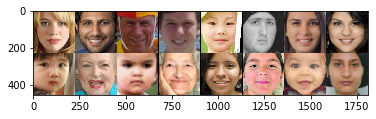

1 : 14-30 female White
2 : 30-45 male Not common race
3 : 60+ male White
4 : 30-45 male White
5 : 5-14 female Asian
6 : 14-30 male White
7 : 14-30 male Not common race
8 : 14-30 female White
9 : 0-5 female Asian
10 : 60+ male White
11 : 0-5 female White
12 : 60+ male White
13 : 30-45 female White
14 : 30-45 female White
15 : 0-5 female White
16 : 14-30 female Indian


In [13]:
import torch.optim as optim
from IPython.display import clear_output

for model_name in model_labels:
    print("Model: " + str(model_name))
    
    model = Net(net=model_name).to(device)
    
    for optimizer_name in optimizer_labels:
        
        print("Training with " + str(optimizer_name) + " optimizer")

        criterion = nn.CrossEntropyLoss()
        
        if (optimizer_name == "SGD"):
            optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)
        
        if (optimizer_name == "Adam"):
            optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        

        print ("Training start. Total number of epochs: " + str(epochs_count))
        for epoch in range(epochs_count):  # loop over the dataset multiple times

            for phase in ['train', 'valid']:

                if phase == 'train':

                    model.train(True)

                    running_loss = 0.0
                    correct = 0
                    total = 0

                    age_correct = 0
                    gender_correct = 0
                    race_correct = 0

                    for i, data in enumerate(train_loader):
                        #  get the inputs; data is a list of [inputs, labels]
                        inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward + backward + optimize
                        out_age, out_gender, out_race = model(inputs)

                        loss_age = criterion(out_age, age)
                        loss_gender = criterion(out_gender, gender)
                        loss_race = criterion(out_race, race)

                        loss = loss_age + loss_gender + loss_race

                        loss.backward()
                        optimizer.step()

                        # print statistics
                        running_loss += loss.item()

                        _, age_pred = torch.max(out_age.data, 1)
                        _, gender_pred = torch.max(out_gender.data, 1)
                        _, race_pred = torch.max(out_race.data, 1)

                        total += gender.size(0)

                        age_correct += (age_pred == age).sum().item()
                        gender_correct += (gender_pred == gender).sum().item()
                        race_correct += (race_pred == race).sum().item()


                elif phase == 'valid':

                    model.train(False)

                    validation_loss = 0.0
                    v_correct = 0
                    v_total = 0

                    v_age_correct = 0
                    v_gender_correct = 0
                    v_race_correct = 0

                    for i, v_data in enumerate(valid_loader):
                        v_loss_age = 0
                        v_loss_gender = 0
                        v_loss_race = 0
                        v_inputs, v_age, v_gender, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                        v_out_age, v_out_gender, v_out_race = model(v_inputs)

                        v_loss_age += criterion(v_out_age, v_age)
                        v_loss_gender += criterion(v_out_gender, v_gender)
                        v_loss_race += criterion(v_out_race, v_race)

                        validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                        _, v_age_pred = torch.max(v_out_age.data, 1)
                        _, v_gender_pred = torch.max(v_out_gender.data, 1)
                        _, v_race_pred = torch.max(v_out_race.data, 1)

                        v_total += v_gender.size(0)

                        v_age_correct += (v_age_pred == v_age).sum().item()
                        v_gender_correct += (v_gender_pred == v_gender).sum().item()
                        v_race_correct += (v_race_pred == v_race).sum().item()


            print('Epoch %d, loss: %.3f, val_loss: %.3f \n +\
                acc_age: %.3f, val_acc_age: %.3f \n  +\
                acc_gender: %.3f, val_acc_gender: %.3f \n  +\
                acc_race: %.3f, val_acc_race: %.3f' %
                  (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
                    age_correct / total, v_age_correct / v_total,
                    gender_correct / total, v_gender_correct / v_total,
                    race_correct / total, v_race_correct / v_total,
                  ))        

        print("Finished Training")

        print("Preview results on first " + str(predict_demo_packs_limit * 16) + " images")

        for i in range(predict_demo_packs_limit):
            _, data = next(enumerate(valid_loader))

    #     for i, data in enumerate(valid_loader):
            inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

            plt.imshow(torchvision.utils.make_grid(inputs).cpu().numpy().transpose(1,2,0))
            plt.show()

            out_age, out_gender, out_race = model(inputs)

            _, age_pred = torch.max(out_age.data, 1)
            _, gender_pred = torch.max(out_gender.data, 1)
            _, race_pred = torch.max(out_race.data, 1)

            for i in range(len(age_pred)):
                age_pred_i, gender_pred_i, race_pred_i = plain_to_labels(age_pred[i], gender_pred[i], race_pred[i])
                print(i+1, ":", age_pred_i, gender_pred_i, race_pred_i)
      